#Task1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('data.csv')

# Drop irrelevant columns (id and any trailing empty column)
df = df.drop(columns=['id'])
if 'Unnamed: 32' in df.columns:
    df = df.drop(columns=['Unnamed: 32'])

# Encode Diagnosis: M=1, B=0 [cite: 5, 62]
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Separate features and target [cite: 4, 30]
X = df.drop(columns=['diagnosis']).values
y = df['diagnosis'].values

# Feature Scaling (Standardization) - Essential for KNN distance metrics
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_scaled = (X - mean) / std

# Split data: 80% Training, 20% Testing [cite: 3, 29]
np.random.seed(42) # For reproducibility
indices = np.random.permutation(len(X_scaled))
train_size = int(0.8 * len(X_scaled))

train_idx, test_idx = indices[:train_size], indices[train_size:]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [ ]:
class KNNFromScratch:
    def __init__(self, k=3, metric='euclidean', p=3):
        self.k = k
        self.metric = metric
        self.p = p # For Minkowski distance

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def compute_distance(self, x1, x2):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2)**2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        elif self.metric == 'minkowski':
            return np.sum(np.abs(x1 - x2)**self.p)**(1/self.p)
        elif self.metric == 'cosine':
            dot_product = np.dot(x1, x2)
            norm_a = np.linalg.norm(x1)
            norm_b = np.linalg.norm(x2)
            return 1 - (dot_product / (norm_a * norm_b))
        elif self.metric == 'hamming':
            # Hamming on continuous data: count of unequal features
            return np.sum(x1 != x2)
        else:
            raise ValueError("Unsupported metric")

    def predict(self, X):
        predictions = [self._predict_single(x) for x in X]
        return np.array(predictions)

    def _predict_single(self, x):
        # Calculate distances to all training points
        distances = [self.compute_distance(x, x_train) for x_train in self.X_train]
        # Get indices of k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Major vote
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return max(set(k_nearest_labels), key=k_nearest_labels.count)

def calculate_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [ ]:
k_values = [3, 4, 9, 20, 47]
metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'hamming']
results = {metric: [] for metric in metrics}

best_accuracy = 0
best_config = None

for metric in metrics:
    for k in k_values:
        knn = KNNFromScratch(k=k, metric=metric)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        acc = calculate_accuracy(y_test, preds)
        results[metric].append(acc)

        if acc > best_accuracy:
            best_accuracy = acc
            best_config = (k, metric)

print(f"Best Configuration: K={best_config[0]}, Metric={best_config[1]} with Accuracy={best_accuracy:.4f}")

Best Configuration: K=3, Metric=cosine with Accuracy=0.9649


In [ ]:
# Re-run best model
best_k, best_metric = best_config
knn_best = KNNFromScratch(k=best_k, metric=best_metric)
knn_best.fit(X_train, y_train)
y_pred_best = knn_best.predict(X_test)

def get_metrics(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    confusion_matrix = np.array([[tn, fp], [fn, tp]])
    return precision, recall, f1, confusion_matrix

precision, recall, f1, cm = get_metrics(y_test, y_pred_best)

print("\n--- Best Model Results ---")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)


--- Best Model Results ---
Precision: 0.9778
Recall: 0.9362
F1-Score: 0.9565
Confusion Matrix:
[[66  1]
 [ 3 44]]


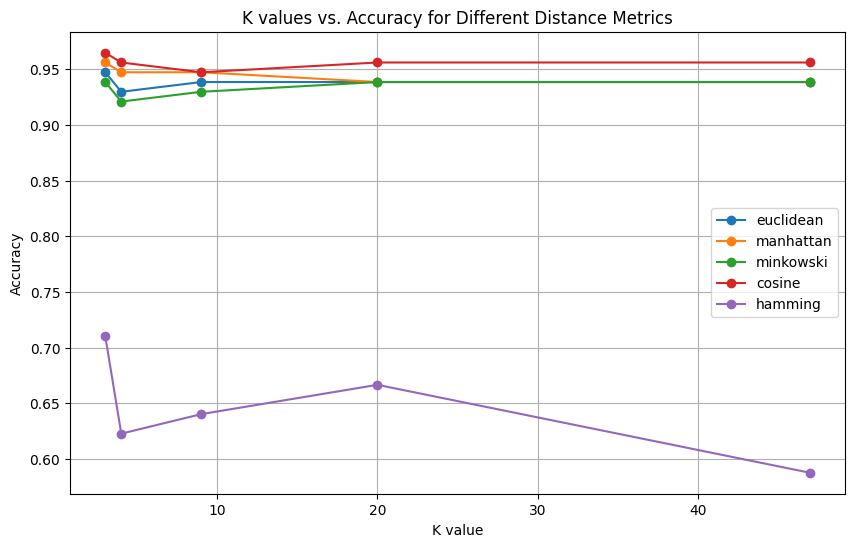

In [ ]:
plt.figure(figsize=(10, 6))
for metric in metrics:
    plt.plot(k_values, results[metric], marker='o', label=metric)

plt.title('K values vs. Accuracy for Different Distance Metrics')
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#Task 2

In [ ]:
import tarfile

# Extracting the file
file_name = "cifar-10-python.tar.gz"
if file_name.endswith("tar.gz"):
    with tarfile.open(file_name, "r:gz") as tar:
        tar.extractall()
        print("Extraction complete.")

/tmp/ipython-input-2426845310.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Extraction complete.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

# 1. DATA LOADING AND PREPROCESSING
def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b'data'], np.array(dict[b'labels'])

def load_data(data_dir):
    # CIFAR-10 consists of 5 batches for training and 1 for testing
    train_x, train_y = [], []
    for i in range(1, 6):
        batch_x, batch_y = load_cifar10_batch(os.path.join(data_dir, f'data_batch_{i}'))
        train_x.append(batch_x)
        train_y.append(batch_y)

    X_train = np.concatenate(train_x)
    y_train = np.concatenate(train_y)

    X_test, y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))

    # Preprocessing: Flatten (3072 features) and Normalize (0-1 range)
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    return X_train, y_train, X_test, y_test

# 2. KNN CLASSIFIER FROM SCRATCH
class KNNClassifier:
    def __init__(self, k=3, metric='euclidean', p=3):
        self.k = k
        self.metric = metric
        self.p = p

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def compute_distance(self, x1, x2):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2)**2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        elif self.metric == 'minkowski':
            return np.sum(np.abs(x1 - x2)**self.p)**(1/self.p)
        elif self.metric == 'cosine':
            # Cosine Distance = 1 - Cosine Similarity
            dot_product = np.dot(x1, x2)
            norm_a = np.linalg.norm(x1)
            norm_b = np.linalg.norm(x2)
            return 1 - (dot_product / (norm_a * norm_b + 1e-8))
        elif self.metric == 'hamming':
            # Percentage of features that are different
            return np.mean(x1 != x2)
        return 0

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            # Calculate distances to all training points
            # Note: For full CIFAR-10, this loop is computationally intensive
            distances = [self.compute_distance(x, x_t) for x_t in self.X_train]

            # Get the labels of the K nearest neighbors
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]

            # Majority vote
            counts = np.bincount(k_nearest_labels)
            predictions.append(np.argmax(counts))
        return np.array(predictions)

# 3. EVALUATION METRICS FROM SCRATCH
def calculate_metrics(y_true, y_pred, num_classes=10):
    # Confusion Matrix [Actual][Predicted]
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    precision_list = []
    recall_list = []

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)

    return cm, np.mean(precision_list), np.mean(recall_list)

# 4. EXPERIMENTATION LOOP
# (Note: Using a subset for demonstration as full CIFAR-10 KNN takes hours)
def run_experiment(X_train, y_train, X_test, y_test):
    k_values = [3, 5, 9, 20]
    metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'hamming']

    results = {m: [] for m in metrics}
    best_acc = 0
    best_config = {}

    for m in metrics:
        for k in k_values:
            knn = KNNClassifier(k=k, metric=m)
            knn.fit(X_train, y_train)
            preds = knn.predict(X_test)

            accuracy = np.mean(preds == y_test)
            results[m].append(accuracy)

            if accuracy > best_acc:
                best_acc = accuracy
                best_config = {'k': k, 'metric': m, 'preds': preds}

    return results, best_config, k_values

# 5. VISUALIZATION
def plot_results(results, k_values):
    plt.figure(figsize=(10, 6))
    for metric, accuracies in results.items():
        plt.plot(k_values, accuracies, label=metric, marker='o')

    plt.title('K-Value vs. Accuracy for CIFAR-10')
    plt.xlabel('Value of K')
    plt.ylabel('Testing Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Execution entry point
# X_train, y_train, X_test, y_test = load_data('path_to_cifar10')
# results, best, ks = run_experiment(X_train[:1000], y_train[:1000], X_test[:100], y_test[:100])
# plot_results(results, ks)
# 1. Provide the path to the folder where you extracted CIFAR-10
# This folder should contain 'data_batch_1', 'test_batch', etc.
data_dir = './cifar-10-batches-py'

# 2. Load and preprocess the data
print("Loading data...")
X_train, y_train, X_test, y_test = load_data(data_dir)

# 3. Run the experiment
# IMPORTANT: KNN is computationally expensive (O(N*D)).
# For testing and plotting, start with a smaller subset of the 50,000 images.
print("Running experiments (this may take a few minutes)...")
train_subset = 2000
test_subset = 200

results, best_config, k_values = run_experiment(
    X_train[:train_subset],
    y_train[:train_subset],
    X_test[:test_subset],
    y_test[:test_subset]
)

# 4. CALL THE PLOTTING FUNCTION
print("Generating plot...")
plot_results(results, k_values)

# 5. Display the best configuration found
print(f"Best Config: K={best_config['k']}, Metric={best_config['metric']}")

Loading data...
Running experiments (this may take a few minutes)...
